In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering,_agglomerative
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score
import json

## Loading the Data

In [2]:
from utils import get_df_description

# load df
df = pd.read_csv('../datasets/df_sample_5000.csv')
print(df.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df, description_json_df)
df_description

(5000, 25)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,object,0,df_orders,
7,fo_order_approved_at,object,0,df_orders,
8,fo_order_delivered_carrier_date,object,0,df_orders,
9,fo_order_delivered_customer_date,object,0,df_orders,


## Create df_numeric
### Only using the numerical features in the data

In [3]:
df_numeric = df.select_dtypes(include=['number']).dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix'])

# df_numeric = df_numeric.sample(1000, random_state=42)
print(df_numeric.shape)
df_numeric.head()

(4834, 12)


,frequency,repeater,recency,monetary,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,customer_in_sao_paulo
0,1,0,376,403.81,403.81,1,1,-10.0,4.0,0.0,1,0
1,1,0,351,95.11,95.11,1,1,0.0,4.0,0.0,1,0
2,1,0,544,215.07,215.07,1,1,-13.0,4.0,0.0,1,1
3,1,0,154,204.12,204.12,1,1,13.0,3.0,0.0,1,1
4,1,0,193,72.84,72.84,1,0,5.0,1.0,0.0,1,0


## Linkage
### Using four different linkage methods(ward, complete, average, single)
### Using three different metrics (euclidean, cosine, cityblock/manhattan, correlation)
#### The method ward can only be used with euclidean distance metric
### The dendograms are printed for each linkage method and metric

In [4]:
def plot_dendrogram(df, method, metric):
    linkage_data = linkage(df, method=method, metric=metric)
    dendrogram(linkage_data)
    plt.title(f'Dendrogram of {method.capitalize()} Method Using {metric.capitalize()} Distance')
    plt.show()

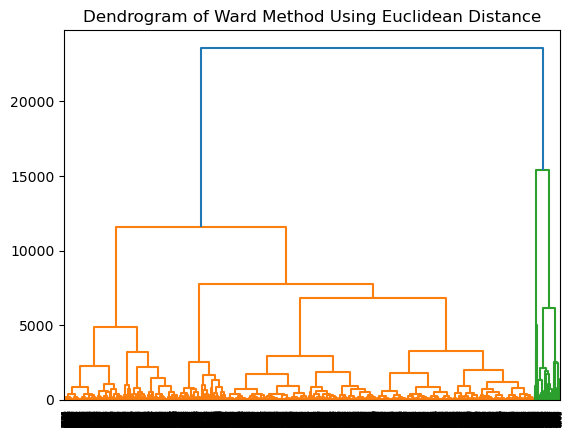

In [5]:
## ward linkage
plot_dendrogram(df_numeric, 'ward', 'euclidean')

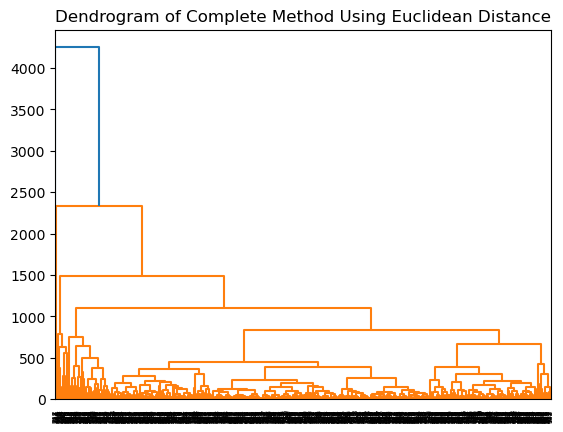

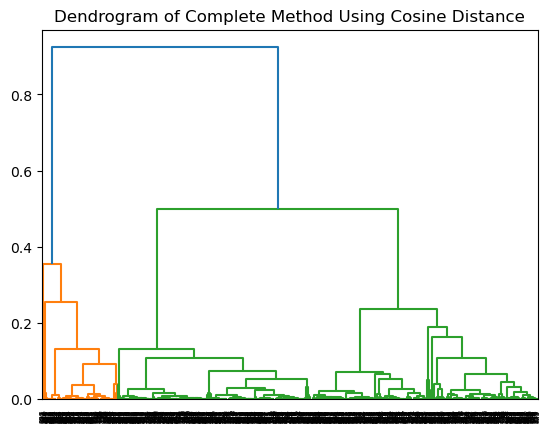

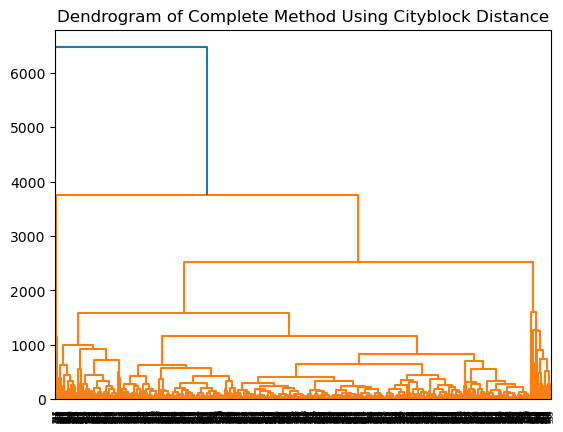

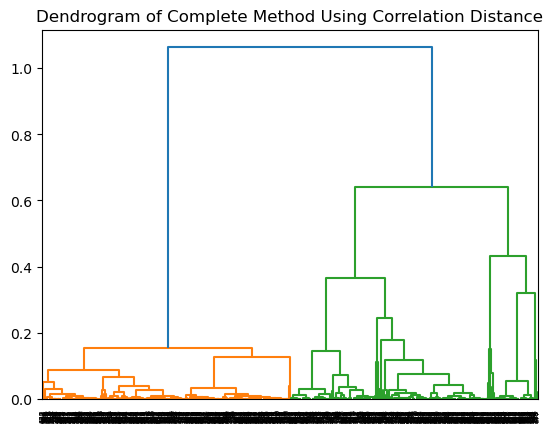

In [51]:
## complete linkage
plot_dendrogram(df_numeric, 'complete', 'euclidean')
plot_dendrogram(df_numeric, 'complete', 'cosine')
plot_dendrogram(df_numeric, 'complete', 'cityblock')
plot_dendrogram(df_numeric, 'complete', 'correlation')

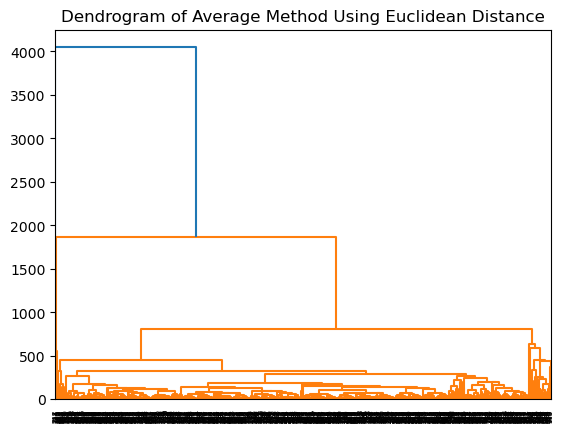

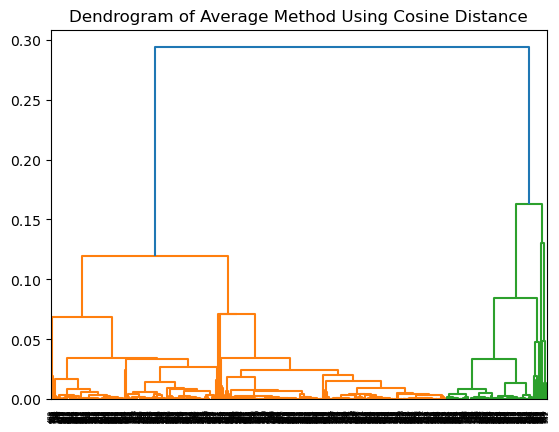

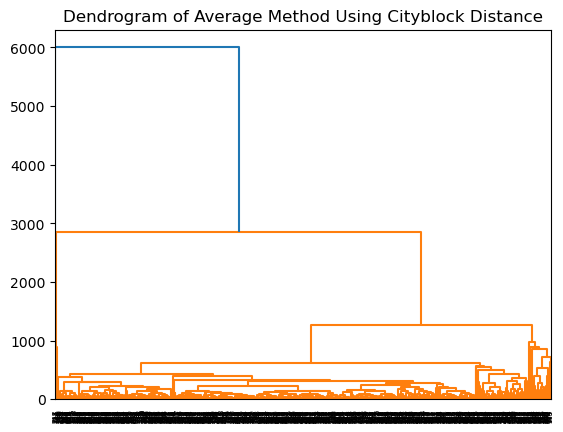

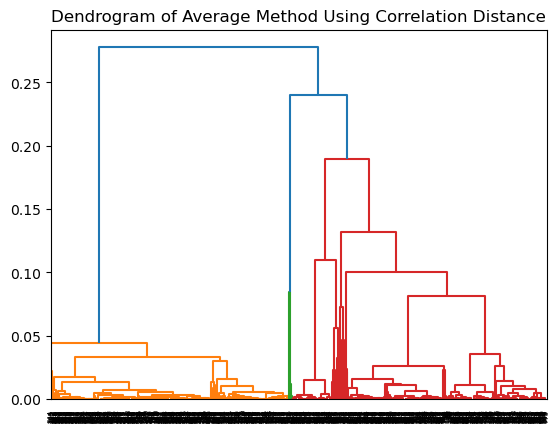

In [52]:
# average linkage
plot_dendrogram(df_numeric, 'average', 'euclidean')
plot_dendrogram(df_numeric, 'average', 'cosine')
plot_dendrogram(df_numeric, 'average', 'cityblock')
plot_dendrogram(df_numeric, 'average', 'correlation')

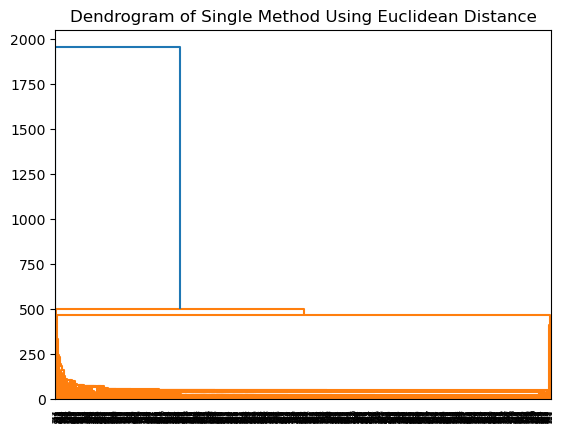

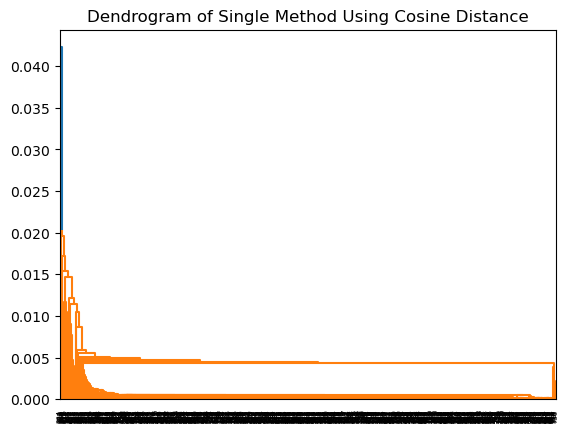

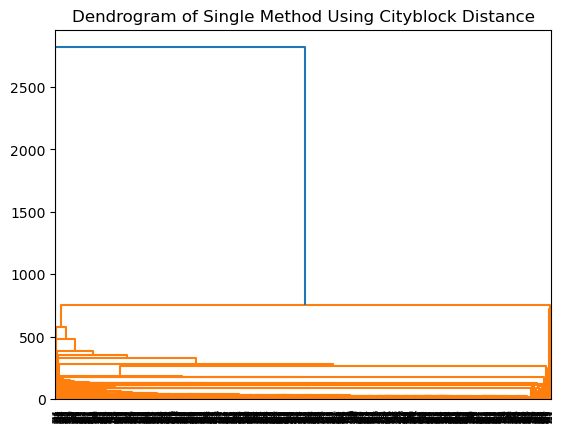

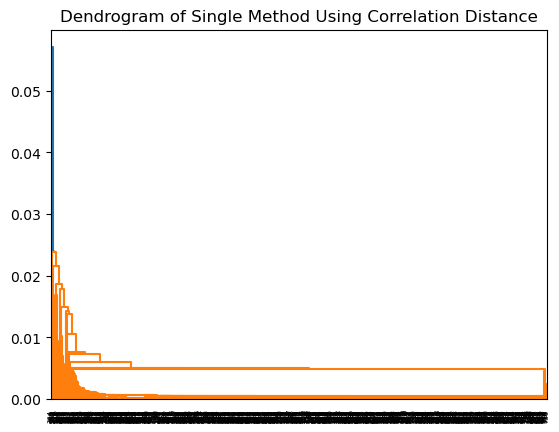

In [53]:
## single linkage
plot_dendrogram(df_numeric, 'single', 'euclidean')
plot_dendrogram(df_numeric, 'single', 'cosine')
plot_dendrogram(df_numeric, 'single', 'cityblock')
plot_dendrogram(df_numeric, 'single', 'correlation')

## Perform Agglomerative Clustering and find Silhouette Score and Davies-Bouldin Index
### Find the optimal number of clusters
### Use agglomerative clustering with different metrics and linkage and find silhouette score and Davies-Bouldin index

In [54]:
def perform_clustering(df, linkage, metric, distance_threshold=400):
    cluster_complete = AgglomerativeClustering(n_clusters=None, metric=metric, linkage=linkage, compute_full_tree=True, distance_threshold=distance_threshold)
    cluster_complete.fit_predict(df)
    optimal_cluster_complete = 1+np.amax(cluster_complete.labels_)
    print(f"Number of clusters for complete using {metric} = {optimal_cluster_complete}")

    if optimal_cluster_complete > 1:
        clustering_complete = AgglomerativeClustering(n_clusters= optimal_cluster_complete, metric=metric,linkage='complete', distance_threshold=None).fit(df)
        labels_complete = clustering_complete.labels_
        silhouette = silhouette_score(df, labels_complete)
        davies_bouldin = davies_bouldin_score(df, labels_complete)
        print(f"Silhouette score for complete using {metric}: {silhouette}")
        print(f"Davies-Bouldin index for complete using {metric}: {davies_bouldin}")
        print()
    else:
        print(f"Silhouette score for complete using {metric}: 'N/A'")
        print(f"Davies-Bouldin index for complete using {metric}: 'N/A'")
        print()


In [55]:
## ward linkage
perform_clustering(df_numeric, 'ward', 'euclidean')

Number of clusters for complete using euclidean = 37
Silhouette score for complete using euclidean: 0.2640798776331829
Davies-Bouldin index for complete using euclidean: 0.67771442326656



In [56]:
## complete linkage
perform_clustering(df_numeric, 'complete', 'euclidean')
perform_clustering(df_numeric, 'complete', 'cosine')
perform_clustering(df_numeric, 'complete', 'cityblock')
perform_clustering(df_numeric, 'complete', 'correlation')

Number of clusters for complete using euclidean = 17
Silhouette score for complete using euclidean: 0.3162295809642285
Davies-Bouldin index for complete using euclidean: 0.7786059861160025

Number of clusters for complete using cosine = 1
Silhouette score for complete using cosine: 'N/A'
Davies-Bouldin index for complete using cosine: 'N/A'

Number of clusters for complete using cityblock = 36
Silhouette score for complete using cityblock: 0.25099872123232125
Davies-Bouldin index for complete using cityblock: 0.8029206201858294

Number of clusters for complete using correlation = 1
Silhouette score for complete using correlation: 'N/A'
Davies-Bouldin index for complete using correlation: 'N/A'



In [57]:
## average linkage
perform_clustering(df_numeric, 'average', 'euclidean')
perform_clustering(df_numeric, 'average', 'cosine')
perform_clustering(df_numeric, 'average', 'cityblock')
perform_clustering(df_numeric, 'average', 'correlation')

Number of clusters for complete using euclidean = 10
Silhouette score for complete using euclidean: 0.3990838681043174
Davies-Bouldin index for complete using euclidean: 0.5866395445469466

Number of clusters for complete using cosine = 1
Silhouette score for complete using cosine: 'N/A'
Davies-Bouldin index for complete using cosine: 'N/A'

Number of clusters for complete using cityblock = 19
Silhouette score for complete using cityblock: 0.29373354173665267
Davies-Bouldin index for complete using cityblock: 0.7847594245544286

Number of clusters for complete using correlation = 1
Silhouette score for complete using correlation: 'N/A'
Davies-Bouldin index for complete using correlation: 'N/A'



In [58]:
## single linkage
perform_clustering(df_numeric, 'single', 'euclidean')
perform_clustering(df_numeric, 'single', 'cosine')
perform_clustering(df_numeric, 'single', 'cityblock')
perform_clustering(df_numeric, 'single', 'correlation')

Number of clusters for complete using euclidean = 5


Silhouette score for complete using euclidean: 0.47411920341210295
Davies-Bouldin index for complete using euclidean: 0.6262517902688575

Number of clusters for complete using cosine = 1
Silhouette score for complete using cosine: 'N/A'
Davies-Bouldin index for complete using cosine: 'N/A'

Number of clusters for complete using cityblock = 7
Silhouette score for complete using cityblock: 0.3580767292771548
Davies-Bouldin index for complete using cityblock: 0.6805327009416554

Number of clusters for complete using correlation = 1
Silhouette score for complete using correlation: 'N/A'
Davies-Bouldin index for complete using correlation: 'N/A'

